In [217]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [218]:
data = pd.read_csv(r'C:\Users\dvale\TFM\Data\all_variables.csv')

In [219]:
data = data[data.age > 18].reset_index(drop=True)

In [220]:
print(data.shape)
print(data.columns)

(32514, 27)
Index(['Unnamed: 0', 'id', 'weight', 'sex', 'age', 'civil_status',
       'familial_status', 'region', 'population_density', 'citizenship',
       'tenure_status', 'education_level', 'working_status',
       'working_status_agg', 'occupation', 'economic_sector', 'years_worked',
       'hours_week_worked', 'household_income', 'person_room',
       'self_perceived_bad_health', 'has_health_limitations',
       'has_chronic_condition', 'unmet_medical_treatment', 'has_support_net',
       'adjusted_income', 'poverty_score'],
      dtype='object')


In [221]:
data = data.drop(['Unnamed: 0', 'id', 'weight', 'economic_sector', 'household_income'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32514 entries, 0 to 32513
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sex                        32514 non-null  object 
 1   age                        32514 non-null  int64  
 2   civil_status               32514 non-null  object 
 3   familial_status            32514 non-null  object 
 4   region                     32514 non-null  object 
 5   population_density         32514 non-null  object 
 6   citizenship                32514 non-null  object 
 7   tenure_status              32514 non-null  object 
 8   education_level            32514 non-null  object 
 9   working_status             32514 non-null  object 
 10  working_status_agg         32514 non-null  object 
 11  occupation                 32514 non-null  object 
 12  years_worked               32514 non-null  int64  
 13  hours_week_worked          32514 non-null  int

In [222]:
data.person_room = data.person_room.fillna(data.person_room.median())

In [223]:
data.working_status.unique()

array(['Retired', 'Unpaid carer/domestic worker',
       'Disabled/unfit to work', 'Unemployed', 'Student', 'Employed',
       'Self-employed'], dtype=object)

In [224]:
data.working_status = np.where(data.working_status == 'Self-employed', 'Employed', data.working_status)
data.working_status.unique()

array(['Retired', 'Unpaid carer/domestic worker',
       'Disabled/unfit to work', 'Unemployed', 'Student', 'Employed'],
      dtype=object)

In [225]:
data = data.drop(['working_status_agg'], axis=1)

In [226]:
scaler = StandardScaler()

num_var = data[['age', 'years_worked', 'hours_week_worked', 'person_room']]
scaler.fit(num_var)
scaled_var = pd.DataFrame(scaler.transform(num_var), columns=num_var.columns)

data.age = scaled_var.age
data.years_worked = scaled_var.years_worked
data.hours_week_worked = scaled_var.hours_week_worked
data.person_room = scaled_var.person_room

data.head()

,sex,age,civil_status,familial_status,region,population_density,citizenship,tenure_status,education_level,working_status,...,years_worked,hours_week_worked,person_room,self_perceived_bad_health,has_health_limitations,has_chronic_condition,unmet_medical_treatment,has_support_net,adjusted_income,poverty_score
0,Male,0.972748,Married,No,Basque Country,Thinly-populated area,Spain,Outright owner,Upper secondary education,Retired,...,1.660637,-0.890916,0.430935,Yes,Yes,Yes,No,Yes,24418.740,0.000000
1,Female,0.861438,Married,No,Basque Country,Thinly-populated area,Spain,Outright owner,Upper secondary education,Unpaid carer/domestic worker,...,-1.205845,-0.890916,0.430935,No,No,Yes,No,Yes,24418.740,0.000000
2,Female,1.084058,Married,No,Basque Country,Thinly-populated area,Spain,Outright owner,Lower secondary education,Unpaid carer/domestic worker,...,-0.059252,-0.890916,0.430935,No,No,No,No,Yes,31261.480,0.000000
3,Male,0.416197,Married,No,Basque Country,Thinly-populated area,Spain,Outright owner,Upper secondary education,Retired,...,0.896242,-0.890916,0.430935,No,No,No,No,Yes,31261.480,0.000000
4,Female,0.082267,Divorced,Yes,Basque Country,Thinly-populated area,Spain,Outright owner,Higher education,Disabled/unfit to work,...,0.577744,-0.890916,-0.322031,No,Yes,Yes,No,Yes,6007.805,5.603701


In [227]:
def get_dummies(df):
    new_df = pd.DataFrame()
    for c in df.columns:
        if type(df[c][0]) == type('string'):
            dummy_df = pd.get_dummies(df[c])
            for dummy_column in dummy_df.columns:
                new_df[c + '_' + dummy_column] = dummy_df[dummy_column]
        else:
            new_df[c] = df[c]
    return new_df

In [228]:
data_final = get_dummies(data)

data_final.columns[:5]

Index(['sex_Female', 'sex_Male', 'age', 'civil_status_Divorced',
       'civil_status_Married'],
      dtype='object')

In [229]:
#data_final['is_minor'] = data_final.civil_status_Minor
#data_final = data_final.drop(['civil_status_Minor', 
#                               'working_status_Minor', 
#                               'education_level_Minor'], axis=1)

In [230]:
data_final['material_deprivation'] = data.poverty_score.apply(lambda x: 1 if x > 2.02 else 0)
data_final = data_final.drop(['poverty_score'], axis=1)

count_yes = len(data_final[data_final.material_deprivation == 1])
count_no = len(data_final[data_final.material_deprivation == 0])
freq_yes = (count_yes/(count_yes+count_no))*100
freq_no = (count_no/(count_yes+count_no))*100

print('''Has material deprivation: {}%
Does not have material deprivation: {}%'''.format(round(freq_yes, 2), round(freq_no, 2)))

Has material deprivation: 20.16%
Does not have material deprivation: 79.84%


In [231]:
data_final.head()

,sex_Female,sex_Male,age,civil_status_Divorced,civil_status_Married,civil_status_Married 'de facto',civil_status_Never married,civil_status_Separated,civil_status_Widowed,familial_status_No,...,has_health_limitations_No,has_health_limitations_Yes,has_chronic_condition_No,has_chronic_condition_Yes,unmet_medical_treatment_No,unmet_medical_treatment_Yes,has_support_net_No,has_support_net_Yes,adjusted_income,material_deprivation
0,0,1,0.972748,0,1,0,0,0,0,1,...,0,1,0,1,1,0,0,1,24418.740,0
1,1,0,0.861438,0,1,0,0,0,0,1,...,1,0,0,1,1,0,0,1,24418.740,0
2,1,0,1.084058,0,1,0,0,0,0,1,...,1,0,1,0,1,0,0,1,31261.480,0
3,0,1,0.416197,0,1,0,0,0,0,1,...,1,0,1,0,1,0,0,1,31261.480,0
4,1,0,0.082267,1,0,0,0,0,0,0,...,0,1,0,1,1,0,0,1,6007.805,1


In [232]:
X = data_final.drop(['material_deprivation'], axis=1)
y = data_final.material_deprivation

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [233]:
frac = y_train.sum()/y_train.count()

training_data = X_train.copy()
training_data['material_deprivation'] = y_train.copy()
training_data_us = pd.concat([training_data[training_data.material_deprivation == 1], 
                              training_data[training_data.material_deprivation == 0].sample(frac=frac)]).sample(frac=1)

X_train_us = training_data_us.drop(['material_deprivation'], axis=1)
y_train_us = training_data_us.material_deprivation

In [234]:
X_train_us = X_train_us#[selected_columns]
X_test = X_test#[selected_columns]

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_us, y_train_us)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.71


In [235]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[4464 2075]
 [ 306 1284]]


In [236]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.68      0.79      6539
           1       0.38      0.81      0.52      1590

    accuracy                           0.71      8129
   macro avg       0.66      0.75      0.65      8129
weighted avg       0.83      0.71      0.74      8129



In [237]:
proba_material_deprivation = [proba[1] for proba in logreg.predict_proba(X_test)]

In [238]:
testing_data = X_test.copy()
testing_data['material_deprivation'] = y_test.copy()
testing_data['proba_material_deprivation'] = proba_material_deprivation

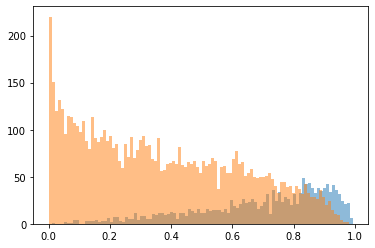

In [239]:
plt.hist(x='proba_material_deprivation', bins=100, data=testing_data[testing_data.material_deprivation == 1].reset_index(), 
         alpha=0.5, density=False)
plt.hist(x='proba_material_deprivation', bins=100, data=testing_data[testing_data.material_deprivation == 0].reset_index(), 
         alpha=0.5, density=False);